In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy
import sklearn
from sklearn import linear_model
from sklearn.metrics import r2_score
import seaborn as sns
%matplotlib inline

In [3]:
crime = pd.read_excel('new_york_crime_by_city_2013.xls')
df_crime = pd.DataFrame.from_dict(crime)
df_crime = df_crime.drop('Rape\n(revised\ndefinition)1', 1)
df_crime.columns = ['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Robbery', 'Aggravated_Assault',
                   'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft', 'Arson']

In [4]:
df_crime = df_crime[['Population', 'Murder', 'Robbery', 'Property_Crime']].dropna()

#print(df_crime.columns)

In [5]:
#creating a squared column for population
df_crime['population_2'] = (df_crime['Population']**2)

#creating a binary column for murder
df_crime['Murder_Feature'] = 0
df_crime.loc[
    (df_crime['Murder'] > 0),
    'Murder_Feature'
] = 1

#creating a binary column for robbery
df_crime['Robbery_Feature'] = 0
df_crime.loc[
    (df_crime.Robbery > 0),
    'Robbery_Feature'
] = 1

#creating a column to wrangle the population differences
df_crime['Major_City'] = 0
df_crime.loc[
    (df_crime.Population > 40000),
    'Major_City'
] = 1

In [6]:
df_crime.head()

,Population,Murder,Robbery,Property_Crime,population_2,Murder_Feature,Robbery_Feature,Major_City
0,1861.0,0.0,0.0,12.0,3.463321e+06,0,0,0
1,2577.0,0.0,0.0,24.0,6.640929e+06,0,0,0
2,2846.0,0.0,0.0,16.0,8.099716e+06,0,0,0
3,97956.0,8.0,227.0,4090.0,9.595378e+09,1,1,1
4,6388.0,0.0,4.0,223.0,4.080654e+07,0,1,0


In [7]:
df_crime.Population.describe()

count    3.480000e+02
mean     4.003763e+04
std      4.500374e+05
min      5.260000e+02
25%      3.003000e+03
50%      7.233500e+03
75%      1.842750e+04
max      8.396126e+06
Name: Population, dtype: float64

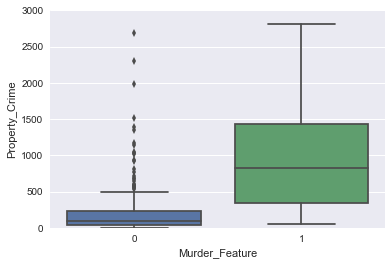

In [8]:
# boxplot showing the property crime distirbution based on the Murder Feature
plt.ylim(0, 3000)
sns.boxplot(y = 'Property_Crime', x = 'Murder_Feature', data = df_crime)

It looks like property crime is significantly more probable/common when a town's crimes include murder

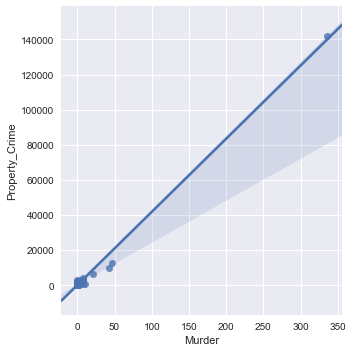

In [9]:
# plotting the murder rate against property crime rate
sns.lmplot('Murder', 'Property_Crime', data = df_crime)

Since the x and y axis are not to scale I'm not sure if interpreting the strong slope visually means anything. I wish there was a way to have the lmplot also output the equation it came up with.

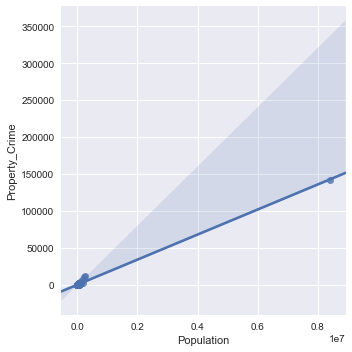

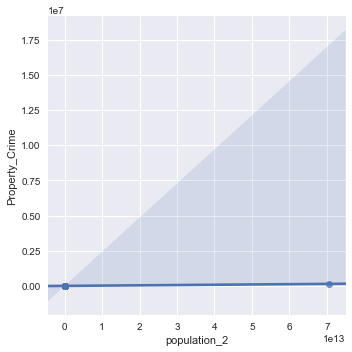

In [10]:
#Plotting both population and population squared against the property crime rate
sns.lmplot('Population', 'Property_Crime', data = df_crime)
sns.lmplot('population_2', 'Property_Crime', data = df_crime)
plt.show()

Logically speaking the bottom graph should have a shallower slope but there does not seem like a good way to plot this.

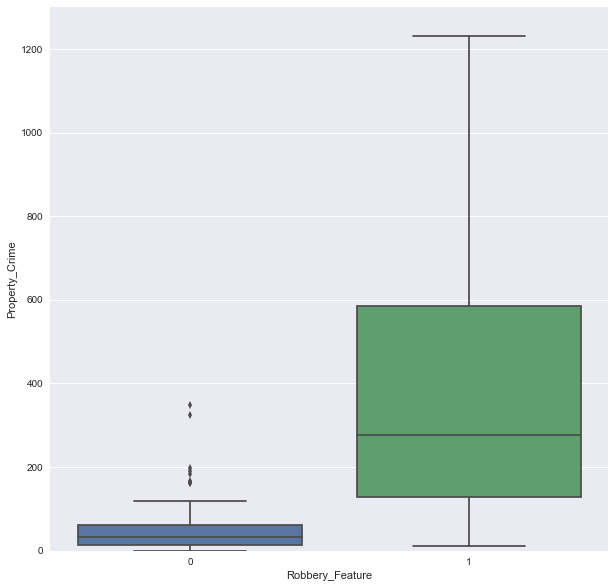

In [11]:
#Plotting distribution of property crime against the robbery feature
plt.figure(figsize = (10, 10))
plt.ylim(0,1300)
sns.boxplot(x = 'Robbery_Feature', y = 'Property_Crime', data = df_crime)

This plot would be a lot easier to see if I could turn it on its side but switching x and y do not have that effect.

## Data Issues

The main thing is going to be dealing with outliers and the main outlier for all of them is New York City. It skews everything. I created a dataframe just for that purpose and it worked better but it is still being skewed high on counts because of some of the major cities. A second dataframe might be worth it similar to the 'Major City' feature I created that only contains those types of cities. That would provide much cleaner analysis of crimes.

Truth be told I think it would be extremely difficult to model all of these cities into one model, but rather than writing multiple models perhaps you could have a tier system. Since NYC is out you will only need four tiers. A Tier 1 city could be the major cities below(population range 100k or above). A Tier 2 city would range from that 95th percentile mark up to the 100k mark in population and encompass the rest of the outliers. Tier 3 cities would be from the Median to the 95th percentile mark and Tier 4 would be every city below the Median. 

So instead of building separate models the Tier system would provide a number that the model could incorporate into the equation that would alter probabilities of Murder and Robbery features.

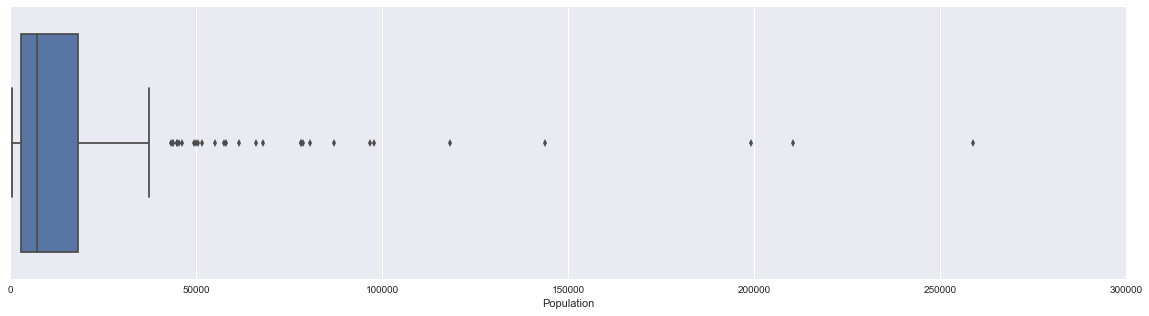

In [12]:
plt.figure(figsize = (20, 5))
plt.xlim(-5,300000)
sns.boxplot(x = 'Population', data = df_crime)

## Regression model building

In [13]:
df_crime.columns #model is propertycrime = a + population + population^2 + Murder_feature + Robbery_feature

Index(['Population', 'Murder', 'Robbery', 'Property_Crime', 'population_2',
       'Murder_Feature', 'Robbery_Feature', 'Major_City'],
      dtype='object')

In [14]:
x = df_crime[['Population', 'population_2', 'Murder_Feature', 'Robbery_Feature', 'Major_City']]
y = df_crime['Property_Crime']

regr = linear_model.LinearRegression()
regr.fit(x,y)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(x,y))


Coefficients: 
 [  3.74134129e-02  -2.43432501e-09   7.35254352e+01  -1.06325917e+02
  -3.91488220e+02]
Intercept: 
 -122.567043799

R-squared: 
 0.99620639714


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [15]:
x = df_crime[['population_2', 'Murder_Feature', 'Robbery_Feature', 'Major_City']]
y = df_crime['Property_Crime']

regr = linear_model.LinearRegression()
regr.fit(x,y)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(x,y))

#x.describe()

Coefficients: 
 [  1.97700157e-09   4.32186017e+02   1.93346614e+02   1.94543191e+03]
Intercept: 
 45.4959437395

R-squared: 
 0.989587837549


In [16]:
x = df_crime[['Population', 'Murder_Feature', 'Robbery_Feature', 'Major_City']]
y = df_crime['Property_Crime']

regr = linear_model.LinearRegression()
regr.fit(x,y)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(x,y))

#x.describe()

Coefficients: 
 [  1.67971775e-02   2.68885173e+02   5.91185775e+01   8.89294741e+02]
Intercept: 
 -29.9416242434

R-squared: 
 0.994193809177


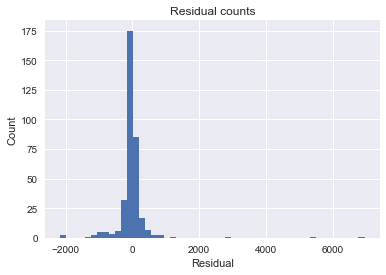

In [17]:
# Extract predicted values.
predicted = regr.predict(x).ravel()
actual = df_crime['Property_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual, bins = 50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [18]:
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [19]:
#model is propertycrime = a + population + population^2 + Murder_feature + Robbery_feature
linear_formula = 'Property_Crime ~ population_2+Murder_Feature+Robbery_Feature'

lm = smf.ols(formula = linear_formula, data = df_crime).fit()

In [20]:
lm.params

Intercept          4.008610e+01
population_2       1.992561e-09
Murder_Feature     1.184060e+03
Robbery_Feature    3.000526e+02
dtype: float64

In [21]:
lm.pvalues

Intercept           6.041530e-01
population_2       4.349813e-318
Murder_Feature      2.738344e-14
Robbery_Feature     4.510728e-03
dtype: float64

Interestingly, when I ran this with the Population column instead of population squared the robbery feature had a really high p_value. 

In [22]:
lm.rsquared #seems kind of high...overfit?

0.98598712040301306

In [23]:
lm.f_pvalue

2.3487090298259515e-318

In [24]:
#checking the model against a new state's crime data
crime2 = pd.read_excel('Michigan_crime_by_city_2013.xls', skiprows = 4)
df_crime2 = pd.DataFrame.from_dict(crime2)
df_crime2.columns = ['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Rape2', 'Robbery', 'Aggravated_Assault',
                   'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft', 'Arson']
df_crime2 = df_crime2.drop('Rape2',1).dropna()

In [25]:
df_crime2.head()

,City,Population,Violent_Crime,Murder,Rape,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft,Arson
0,Akron,394.0,1.0,0.0,0.0,0.0,1.0,6.0,3.0,3.0,0.0,0.0
1,Albion,8524.0,58.0,0.0,10.0,13.0,35.0,240.0,86.0,144.0,10.0,3.0
2,Allegan,5055.0,17.0,0.0,9.0,1.0,7.0,83.0,6.0,72.0,5.0,1.0
3,Allen Park,27601.0,35.0,0.0,7.0,4.0,24.0,662.0,100.0,474.0,88.0,4.0
4,Alma,9256.0,22.0,1.0,8.0,3.0,10.0,208.0,27.0,180.0,1.0,1.0


In [26]:
#creating a squared column for population
df_crime2['population_2'] = (df_crime2['Population']**2)

#creating a binary column for murder
df_crime2['Murder_Feature'] = 0
df_crime2.loc[
    (df_crime2['Murder'] > 0),
    'Murder_Feature'
] = 1

#creating a binary column for robbery
df_crime2['Robbery_Feature'] = 0
df_crime2.loc[
    (df_crime2.Robbery > 0),
    'Robbery_Feature'
] = 1

#creating a column to wrangle the population differences
df_crime2['Major_City'] = 0
df_crime2.loc[
    (df_crime2.Population > 40000),
    'Major_City'
] = 1

In [27]:
mich_y_pred = lm.predict(df_crime2[['population_2', 'Murder_Feature', 'Robbery_Feature']])

In [28]:
r2_score(df_crime2['Property_Crime'], mich_y_pred)

0.1180978416977827

Clearly there was significant overfitting of my model

# Building a new model 

In [29]:
#start building new features from the original(NY) dataset in order to build a new model
NY_Crime = pd.read_excel('new_york_crime_by_city_2013.xls')
df_NY_crime = pd.DataFrame.from_dict(NY_Crime)
df_NY_crime.columns = ['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Rape2', 'Robbery', 'Aggravated_Assault',
                   'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft', 'Arson']
df_NY_crime = df_NY_crime.drop('Rape',1)
df_NY_crime.head()

,City,Population,Violent_Crime,Murder,Rape2,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft,Arson
0,Adams Village,1861.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0
1,Addison Town and Village,2577.0,3.0,0.0,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0
2,Akron Village,2846.0,3.0,0.0,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0
3,Albany,97956.0,791.0,8.0,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,NaN
4,Albion Village,6388.0,23.0,0.0,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN


In [30]:
#Feature Building

#Feature list so far will be Population, Major City, Larceny_Theft, Violent_Crime, Murder_Feature

#Major City feature
df_NY_crime['Major_City'] = 0 

df_NY_crime.loc[
    (df_NY_crime.Population > 50000),
    'Major_City'
] = 1

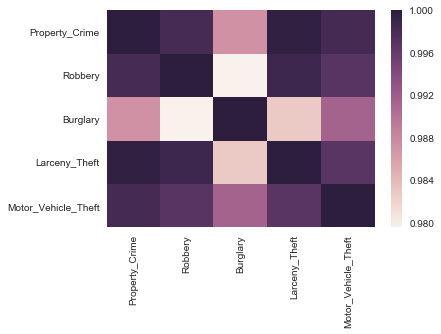

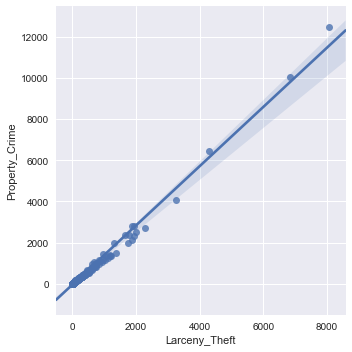

In [74]:
sns.heatmap(df_NY_crime[['Property_Crime',
                               'Robbery', 'Burglary', 
                               'Larceny_Theft', 
                               'Motor_Vehicle_Theft']].corr())
plt.show()

#Based on the heatmap below it seems like I could drop all features except Larceny_Theft and still achieve pretty
#good predictive power

sns.lmplot(x = 'Larceny_Theft', y = 'Property_Crime', data = df_NY_crime.loc[(df_NY_crime.City != 'New York')])
plt.show()

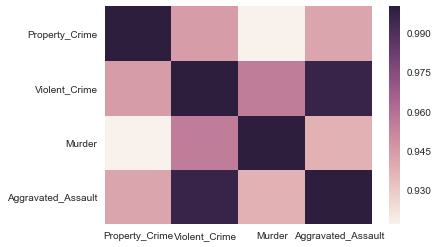

                    Property_Crime  Violent_Crime    Murder  \
Property_Crime            1.000000       0.998059  0.995403   
Violent_Crime             0.998059       1.000000  0.992098   
Murder                    0.995403       0.992098  1.000000   
Aggravated_Assault        0.997622       0.999942  0.990843   

                    Aggravated_Assault  
Property_Crime                0.997622  
Violent_Crime                 0.999942  
Murder                        0.990843  
Aggravated_Assault            1.000000  


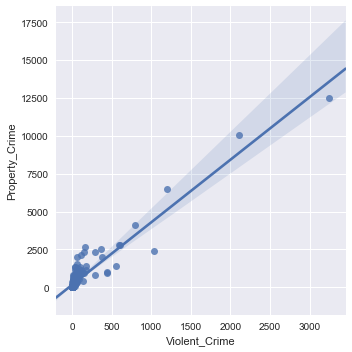

In [76]:
sns.heatmap(df_NY_crime.loc[(df_NY_crime.City != 'New York'),
                            ['Property_Crime','Violent_Crime', 'Murder', 'Aggravated_Assault']].corr())
plt.show()

print(df_NY_crime[['Property_Crime','Violent_Crime', 'Murder', 'Aggravated_Assault']].corr())

sns.lmplot(x = 'Violent_Crime', y = 'Property_Crime', data = df_NY_crime.loc[(df_NY_crime.City != 'New York')])
plt.show()

Both Violent Crime and Aggravated Assault share extremely heavy correlation and variance, Violent Crime however is slightly more strongly correlated to Property Crime so I will use that feature.

In [33]:
df_NY_crime['Murder_Feature'] = 0
df_NY_crime.loc[
    (df_NY_crime.Murder > 0),
    'Murder_Feature'
] = 1

In [45]:
#This is one way of looking at it but I am excluding the major outlier NYC. 
print(df_NY_crime.loc[
    (df_NY_crime.City != 'New York')].groupby('Murder_Feature')['Property_Crime'].mean())

print('<>'*40)

#Another way of looking at it is doing a double groupby where I include the major city feature. This should be
#incorporated into the model so I think this second view is more how the model will look

print(df_NY_crime.groupby(['Major_City', 'Murder_Feature'])['Property_Crime'].mean())

Murder_Feature
0     202.224080
1    1528.979167
Name: Property_Crime, dtype: float64
<><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><><>
Major_City  Murder_Feature
0           0                   169.136519
            1                   700.794118
1           0                  1818.000000
            1                 12769.000000
Name: Property_Crime, dtype: float64


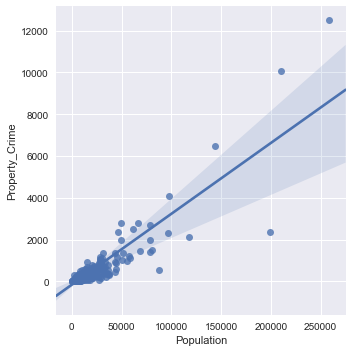

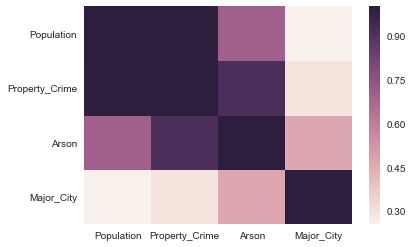

In [77]:
sns.lmplot(x = 'Population', y = 'Property_Crime', data = df_NY_crime.loc[(df_NY_crime.City != 'New York')])
plt.show()

sns.heatmap(df_NY_crime[['Population', 'Property_Crime', 'Arson', 'Major_City']].corr())
plt.show()

In [67]:
df_NY_crime['Arson_Feature'] = 0
df_NY_crime.loc[
    (df_NY_crime.Arson >= 0),
    'Arson_Feature'
] = 1

In [69]:
print(df_NY_crime.groupby('Arson_Feature')['Property_Crime'].mean())
print(df_NY_crime.groupby('Arson_Feature')['Property_Crime'].count())

Arson_Feature
0    1318.509317
1     339.823529
Name: Property_Crime, dtype: float64
Arson_Feature
0    161
1    187
Name: Property_Crime, dtype: int64


In [72]:
#Since half of the data is missing I don't think this column can be reliably used for feature building or in
#the building of a model
df_NY_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 15 columns):
City                   351 non-null object
Population             348 non-null float64
Violent_Crime          348 non-null float64
Murder                 348 non-null float64
Rape2                  348 non-null float64
Robbery                348 non-null float64
Aggravated_Assault     348 non-null float64
Property_Crime         348 non-null float64
Burglary               348 non-null float64
Larceny_Theft          348 non-null float64
Motor_Vehicle_Theft    348 non-null float64
Arson                  187 non-null float64
Major_City             351 non-null int64
Murder_Feature         351 non-null int64
Arson_Feature          351 non-null int64
dtypes: float64(11), int64(3), object(1)
memory usage: 41.2+ KB


### Model Building

Build a df that is just the built features for the model and then perform holdout testing as well as testing on some new crime datasets.

In [79]:
#holdout groups to be built through: train, test = train_test_split(data, test_size = .2, random_state = 1)
from sklearn.model_selection import train_test_split

In [81]:
df_NY_crime.head()
#Population, Major City, Larceny_Theft, Violent_Crime, Murder_Feature

,City,Population,Violent_Crime,Murder,Rape2,Robbery,Aggravated_Assault,Property_Crime,Burglary,Larceny_Theft,Motor_Vehicle_Theft,Arson,Major_City,Murder_Feature,Arson_Feature
0,Adams Village,1861.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0,10.0,0.0,0.0,0,0,1
1,Addison Town and Village,2577.0,3.0,0.0,0.0,0.0,3.0,24.0,3.0,20.0,1.0,0.0,0,0,1
2,Akron Village,2846.0,3.0,0.0,0.0,0.0,3.0,16.0,1.0,15.0,0.0,0.0,0,0,1
3,Albany,97956.0,791.0,8.0,30.0,227.0,526.0,4090.0,705.0,3243.0,142.0,NaN,1,1,0
4,Albion Village,6388.0,23.0,0.0,3.0,4.0,16.0,223.0,53.0,165.0,5.0,NaN,0,0,0


In [87]:
df_NY_crime2 = df_NY_crime[:347]

In [88]:
train, test = train_test_split(df_NY_crime2[['Property_Crime',
                                            'Population', 
                                            'Major_City', 
                                            'Larceny_Theft', 
                                            'Violent_Crime', 
                                            'Murder_Feature']], test_size = .2, random_state = 1)
train.dropna()
test.dropna()

x = train[['Population', 'Major_City', 'Larceny_Theft', 'Violent_Crime', 'Murder_Feature']]
y = train['Property_Crime']

regr = linear_model.LinearRegression()
regr.fit(x,y)

print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('\nR-squared: \n', regr.score(x,y))

Coefficients: 
 [ -8.07106455e-03   1.49905418e+02   1.39527606e+00   8.59045606e-01
   2.44960001e+01]
Intercept: 
 39.143429561

R-squared: 
 0.99991764969


In [92]:
#y_pred = regr.predict(test[['Population', 'Major_City', 'Larceny_Theft', 'Violent_Crime', 'Murder_Feature']])

regr.score(test[['Population', 
                 'Major_City', 
                 'Larceny_Theft', 
                 'Violent_Crime', 
                 'Murder_Feature']], test['Property_Crime'])

0.96351363002363555

Based on the above R_squared score the model seems to work well for the holdout NY data

# Testing the model on Michigan data

In [93]:
#Importing another states crime data and running it against the model
crime2 = pd.read_excel('Michigan_crime_by_city_2013.xls', skiprows = 4)
df_crime2 = pd.DataFrame.from_dict(crime2)
df_crime2.columns = ['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Rape2', 'Robbery', 'Aggravated_Assault',
                   'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft', 'Arson']
df_MI_crime = df_crime2.drop('Rape2',1).dropna()

In [94]:
#Feature building for the michigan crime data

#Population - good to go

#Major City feature
df_MI_crime['Major_City'] = 0 

df_MI_crime.loc[
    (df_MI_crime.Population > 50000),
    'Major_City'
] = 1

#Larceny Theft - good to go

#Violent Crime = good to go

#Murder Feature
df_MI_crime['Murder_Feature'] = 0
df_MI_crime.loc[
    (df_MI_crime.Murder > 0),
    'Murder_Feature'
] = 1

In [97]:
regr.score(df_MI_crime[['Population', 
                        'Major_City', 
                        'Larceny_Theft', 
                        'Violent_Crime', 
                        'Murder_Feature']], df_MI_crime['Property_Crime'])

0.94348134866596922

That seems like a strong R-Squared for brand new data, I will run the model on a few other states as well.

# Testing the model on Ohio data

In [98]:
#Importing another states crime data and running it against the model
crime3 = pd.read_excel('ohio_crime_by_city_2013.xls', skiprows = 4)
df_crime3 = pd.DataFrame.from_dict(crime3)
df_crime3.columns = ['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Rape2', 'Robbery', 'Aggravated_Assault',
                   'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft', 'Arson']
df_OH_crime = df_crime3.drop('Rape2',1).dropna()

In [101]:
#Feature building for the ohio crime data

#Population - good to go

#Major City feature
df_OH_crime['Major_City'] = 0 

df_OH_crime.loc[
    (df_OH_crime.Population > 50000),
    'Major_City'
] = 1

#Larceny Theft - good to go

#Violent Crime = good to go

#Murder Feature
df_OH_crime['Murder_Feature'] = 0
df_OH_crime.loc[
    (df_OH_crime.Murder > 0),
    'Murder_Feature'
] = 1

In [102]:
regr.score(df_OH_crime[['Population', 
                        'Major_City', 
                        'Larceny_Theft', 
                        'Violent_Crime', 
                        'Murder_Feature']], df_OH_crime['Property_Crime'])

0.95094350572585384

The Ohio crime data R-Squared is even better than michigan so I am very happy with this model. I will test on two more states with vastly different populations to see how it holds up.

# Testing the model on California data

In [113]:
#Importing another states crime data and running it against the model
crime4 = pd.read_excel('california_crime_by_city_2013.xls', skiprows = 4)
df_crime4 = pd.DataFrame.from_dict(crime4)
df_crime4.columns = ['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Rape2', 'Robbery', 'Aggravated_Assault',
                   'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft', 'Arson']
df_CA_crime = df_crime4.drop('Rape2',1)
df_CA_crime = df_CA_crime.drop('Rape', 1)
df_CA_crime = df_CA_crime[:461]

In [116]:
#Feature building for the california crime data

#Population - good to go

#Major City feature
df_CA_crime['Major_City'] = 0 

df_CA_crime.loc[
    (df_CA_crime.Population > 50000),
    'Major_City'
] = 1

#Larceny Theft - good to go

#Violent Crime = good to go

#Murder Feature
df_CA_crime['Murder_Feature'] = 0
df_CA_crime.loc[
    (df_CA_crime.Murder > 0),
    'Murder_Feature'
] = 1

In [117]:
regr.score(df_CA_crime[['Population', 
                        'Major_City', 
                        'Larceny_Theft', 
                        'Violent_Crime', 
                        'Murder_Feature']], df_CA_crime['Property_Crime'])

0.91347293245925221

The score isn't as good for california and I am wondering if it has something to do with the amount of potential 'Major Cities' in that state.

# Testing the model on Vermont

In [122]:
#Importing another states crime data and running it against the model
crime5 = pd.read_excel('vermont_crime_by_city_2013.xls', skiprows = 4)
df_crime5 = pd.DataFrame.from_dict(crime5)
df_crime5.columns = ['City', 'Population', 'Violent_Crime', 'Murder', 'Rape', 'Rape2', 'Robbery', 'Aggravated_Assault',
                   'Property_Crime', 'Burglary', 'Larceny_Theft', 'Motor_Vehicle_Theft', 'Arson']
df_VT_crime = df_crime5.drop('Rape2',1)
df_VT_crime = df_VT_crime.drop('Rape', 1)
df_VT_crime = df_VT_crime[:34]

In [124]:
#Feature building for the vermont crime data

#Population - good to go

#Major City feature
df_VT_crime['Major_City'] = 0 

df_VT_crime.loc[
    (df_VT_crime.Population > 50000),
    'Major_City'
] = 1

#Larceny Theft - good to go

#Violent Crime = good to go

#Murder Feature
df_VT_crime['Murder_Feature'] = 0
df_VT_crime.loc[
    (df_VT_crime.Murder > 0),
    'Murder_Feature'
] = 1

In [125]:
regr.score(df_VT_crime[['Population', 
                        'Major_City', 
                        'Larceny_Theft', 
                        'Violent_Crime', 
                        'Murder_Feature']], df_VT_crime['Property_Crime'])

0.97571854195280638

I was curious how this model would run on a very small state and it seems to be holding up pretty well.